In [2]:
import numpy as np
import matplotlib.pyplot as plt
import fullcontrol as fc
import taichi as ti
from tolvera import Tolvera
plt.gcf().set_facecolor("black")
plt.style.use('dark_background')

[Taichi] version 1.7.0, llvm 15.0.7, commit 2fd24490, osx, python 3.11.5


[I 04/06/24 16:50:38.522 32795600] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


<Figure size 640x480 with 0 Axes>

In [3]:
fc_print_speed = 500
fc_max_steps = 4096
fc_bed = (100, 100)# (200, 280)
px_per_mm = 10
tvkw = {
    'x':fc_bed[0]*px_per_mm, 'y': fc_bed[1]*px_per_mm,
    'particles': 1024,
    'headless': True
}
tv = Tolvera(**tvkw)
ti_px_per_mm = ti.field(dtype=ti.f32, shape=())
ti_px_per_mm[None] = px_per_mm

[Tölvera Context] Initializing context...
[Taichi] Starting on arch=vulkan
[Tölvera.Taichi] Running on vulkan
[Tölvera.Taichi] Taichi initialised with: {'ctx': <tolvera.context.TolveraContext object at 0x298000cd0>, 'kwargs': {'x': 1000, 'y': 1000, 'particles': 1024, 'headless': True}, 'gpu': 'vulkan', 'cpu': None, 'fps': 120, 'seed': 1712422240, 'headless': True, 'name': 'Tölvera', 'window': <taichi.ui.window.Window object at 0x298013690>, 'canvas': <taichi.ui.canvas.Canvas object at 0x297ef9350>}
[Tölvera Context] Context initialisation complete.
[Tölvera] Sharing context 'Tölvera Context'.


RHI Error: Potential non-conformant Vulkan implementation, enabling VK_KHR_portability_subset
[W 04/06/24 16:50:40.350 32795600] 
Assign may lose precision: unknown <- f32


[Tölvera Context] Adding tolvera='Tölvera' to context.
[Tölvera] Setup complete.
[Tölvera] Initialisation and setup complete.


[W 04/06/24 16:50:40.509 32795600] 
Assign may lose precision: unknown <- f32
[W 04/06/24 16:50:40.526 32795600] 
Assign may lose precision: unknown <- f32
[W 04/06/24 16:50:40.527 32795600] 
Assign may lose precision: unknown <- f32
[W 04/06/24 16:50:40.529 32795600] 
Assign may lose precision: unknown <- f32
[W 04/06/24 16:50:40.530 32795600] 
Assign may lose precision: unknown <- f32
[W 04/06/24 16:50:40.532 32795600] 
Assign may lose precision: unknown <- i32
[W 04/06/24 16:50:40.543 32795600] 
Assign may lose precision: unknown <- f32
[W 04/06/24 16:50:40.545 32795600] 
Assign may lose precision: unknown <- f32
[W 04/06/24 16:50:40.548 32795600] 
Assign may lose precision: unknown <- f32
[W 04/06/24 16:50:40.549 32795600] 
Assign may lose precision: unknown <- f32
[W 04/06/24 16:50:40.575 32795600] 
Assign may lose precision: unknown <- f32
[W 04/06/24 16:50:40.625 32795600] 
Assign may lose precision: unknown <- f32


In [4]:
@ti.data_oriented
class ParticlesHistory:
    def __init__(self, tv, **kwargs):
        self.tv = tv
        self.max_steps = ti.field(ti.i32, shape=())
        self.max_steps[None] = kwargs.get('max', 4096)
        self.tv.s.hist_p = {
            'state': {
                'pos': (ti.math.vec2, 0, self.tv.x),
                'vel': (ti.math.vec2, 0, 1),
            },
            'shape': (self.tv.pn, self.max_steps[None]),
            'randomise': False
        }
    @ti.kernel
    def process(self, particles: ti.template()):
        for i in range(particles.field.shape[0]):
            p = particles.field[i]
            self.tv.s.hist_p.field[i, self.tv.ctx.i[None] % self.max_steps[None]].pos = p.pos
    @ti.kernel
    def clear(self):
        self.tv.s.field.fill(0)
    def __call__(self, particles):
        self.process(particles)

history = ParticlesHistory(tv, max_steps=fc_max_steps)

[W 04/06/24 16:50:41.480 32795600] 
Assign may lose precision: unknown <- i32


In [5]:
@ti.kernel
def px_to_mm(pos: ti.math.vec2, ti_px_per_mm: ti.f32) -> ti.math.vec2:
    return pos / ti_px_per_mm

def pos_to_point(pos, z):
    pos_mm = px_to_mm(pos, ti_px_per_mm[None])
    return fc.Point(x=pos_mm.x, y=pos_mm.y, z=z)

def substep(clear=False):
    history(tv.p)
    if clear: tv.px.clear()
    tv.p()
    # tv.px.diffuse(0.99)
    tv.v.slime(tv.p, tv.s.species())
    tv.px.particles(tv.p, tv.s.species())
    tv.ctx.i[None] += 1
    return tv.px.px.rgba.to_numpy()

def step(i, clear=False):
    for s in range(i):
        px = substep()
    return px

def plot(im,x=20,y=11.25):
    im = np.transpose(im, (1, 0, 2))
    im[:, :, 3] = 1.0
    im = (255*im).astype(np.uint8)
    plt.figure(figsize=(x,y))
    plt.imshow(im)
    plt.axis('off')
    plt.show()

def step_and_plot(i=0):
    px = step(i)
    plot(px)

def clear():
    history.clear()
    tv.px.clear()

def p_to_fc(p):
    steps = []
    steps.append(fc.Printer(print_speed=fc_print_speed))
    z = 0.0
    z_inc = 0.001
    for i in range(tv.ctx.i[None]):
        point = pos_to_point(tv.s.hist_p.field[p,i].pos, z)
        steps.append(point)
        z += z_inc
    return steps

def plot_p(p):
    steps = p_to_fc(p)
    fc.transform(steps, 'plot', fc.PlotControls(style='line'))
    return steps

[W 04/06/24 16:50:47.407 32795600] 
Assign may lose precision: unknown <- i32


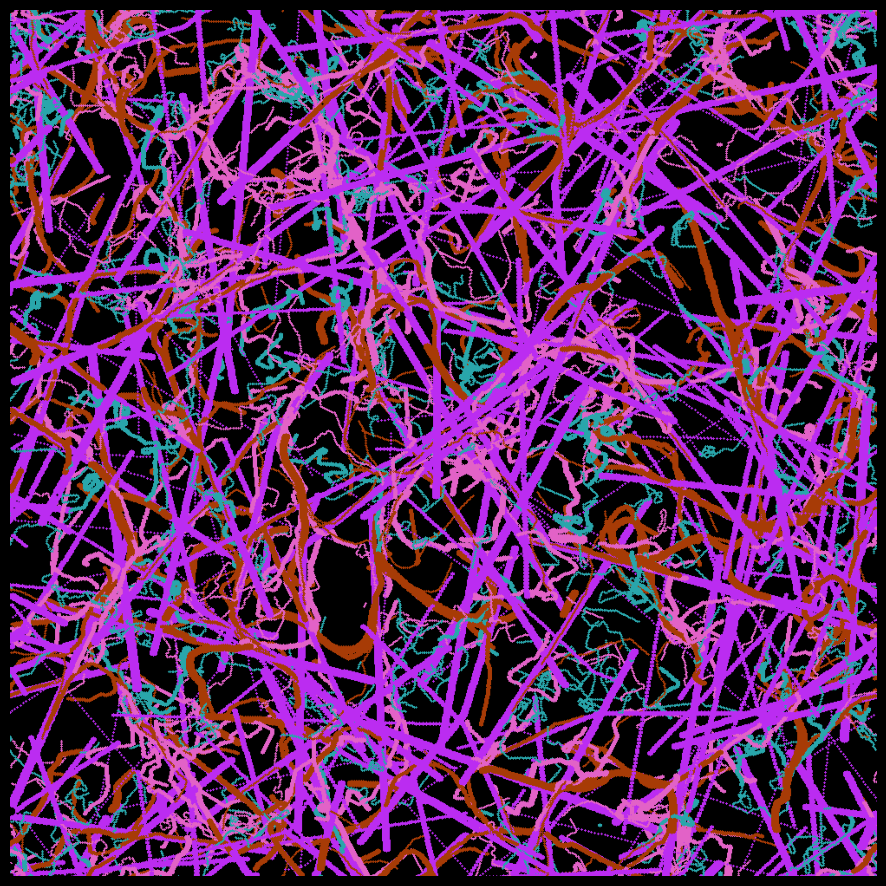

In [6]:
step_and_plot(100)

In [11]:
steps = plot_p(7)

#### set filename, printer and print settings

In [ ]:
filename = 'my_design'
printer = 'ender_3' 
# printer options: generic, ultimaker2plus, prusa_i3, ender_3, cr_10, bambulab_x1, toolchanger_T0, toolchanger_T1, toolchanger_T2, toolchanger_T3
print_settings = {'extrusion_width': 0.5,'extrusion_height': 0.2, 'nozzle_temp': 210, 'bed_temp': 40, 'fan_percent': 100}
# 'extrusion_width' and 'extrusion_height' are the width and height of the printed line)

#### save gcode file to the same directory as this notebook

do not edit this line of code - it uses values defined in the previous code cells

make sure you execute the previous cells before running this one

In [ ]:
fc.transform(steps, 'gcode', fc.GcodeControls(printer_name=printer, save_as=filename, initialization_data=print_settings))